## Here we'll understand how thw CNN layers work and different hyperparameters of it

In [2]:
import torch
from torch import nn
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

from torch.utils.data import dataset
from torch.utils.data import DataLoader

d:\environments\mltorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
train_data = datasets.FashionMNIST(root="Data", 
                             train=True, 
                             transform=torchvision.transforms.ToTensor(),
                             target_transform=None,
                             download=True)

test_data = datasets.FashionMNIST(root="Data",
                                  train=False,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None,
                                  download=True)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# create a dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# 1875 batches --> 60000 / 32
train_dataloader.__len__(), test_dataloader.__len__() 

(1875, 313)

In [8]:
# check the device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Convolutional Neural Network Model

In [9]:
class CNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.layer_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, 
                      out_channels=hidden_dim,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_dim * 7*7, # 7*7 should be calculated, the way to do it is, just write hiddem_dim and pass the data, it'll show the expected dim in err
                      out_features=output_dim)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.layer_block_1(x)
        # print(f"Shape of layer block 1 output: {x.shape}")
        x = self.layer_block_2(x)
        # print(f"Shape of layer block 2 output: {x.shape}")
        x = self.classifier(x)
        # print(f"Shape of classifier output: {x.shape}")

        return x

#### Try Conv2D layer seperately 

In [10]:
img, label = next(iter(train_dataloader))
img.shape # -> [batch_size, color_channels, height, width]

torch.Size([32, 1, 28, 28])

In [11]:
layer = nn.Conv2d(in_channels=1, # No.of channels of the image
          out_channels=10, # output classes you are raining network for
          kernel_size=3, # filter size
          stride=1, # no.of columns filter will move
          padding=0) # extra pixels added around the img to give importance to the corner pixels as well

max_pool_layer = nn.MaxPool2d(kernel_size=2) # to select pixel with the highest value

In [12]:
# passing image through both the layers 

x = layer(img)
print(f"Shape of the image after Conv2D: {x.shape}")
x = max_pool_layer(x)
print(f"Shape of the image after max_pool_layer: {x.shape}")

Shape of the image after Conv2D: torch.Size([32, 10, 26, 26])
Shape of the image after max_pool_layer: torch.Size([32, 10, 13, 13])


### Setup a Train Fxn and Eval Fxn

In [13]:
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    model.train()

    train_acc, train_loss = 0, 0    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy_fn(y_pred, y)

        train_acc += acc
        train_loss += loss

    train_acc /= len(dataloader)
    train_loss /= len(dataloader) 

    print(f"Train loss: {train_loss} | Train acc: {train_acc}")

def eval_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              accuracy_fn,
              device: torch.device = device):
    
    model.eval()
    test_loss, test_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred, y)

        test_loss += loss
        test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test loss: {test_loss} | Test acc: {test_acc}")

### Write the train and Eval loop

In [14]:
model = CNNModel(input_dim=1, # channels of input image
                 hidden_dim=10, # hidden units
                 output_dim=10) # output classes

model.to(device)

CNNModel(
  (layer_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [16]:
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
epochs = 10

start_time = time.time()
for epoch in range(epochs):
    train_step(model, loss_fn, train_dataloader, optimizer, accuracy)
    eval_step(model, loss_fn, test_dataloader, accuracy)

stop_time = time.time()
print(f"Total time taken: {stop_time-start_time} seconds")

Train loss: 0.6785107254981995 | Train acc: 0.7492166757583618
Test loss: 0.3884817361831665 | Test acc: 0.8553314805030823
Train loss: 0.3694513142108917 | Train acc: 0.8667833209037781
Test loss: 0.3513369560241699 | Test acc: 0.870207667350769
Train loss: 0.33025676012039185 | Train acc: 0.8796666860580444
Test loss: 0.34846794605255127 | Test acc: 0.870207667350769
Train loss: 0.3067415952682495 | Train acc: 0.8894667029380798
Test loss: 0.327435165643692 | Test acc: 0.8846845030784607
Train loss: 0.28905731439590454 | Train acc: 0.8947833180427551
Test loss: 0.31552359461784363 | Test acc: 0.8845846652984619
Train loss: 0.2777009904384613 | Train acc: 0.8987166881561279
Test loss: 0.30802664160728455 | Test acc: 0.8861820697784424
Train loss: 0.27023813128471375 | Train acc: 0.9014333486557007
Test loss: 0.2977448105812073 | Test acc: 0.8960662484169006
Train loss: 0.2632457911968231 | Train acc: 0.9040166735649109
Test loss: 0.3005613684654236 | Test acc: 0.8885782361030579
Train

In [33]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device:torch.device = device):
    
    model.to(device)
    model.eval()
    test_probs = []
    with torch.inference_mode():
        for img in data:
            img = img.to(device)
            # print(f"img: {img.shape}")
            raw_logits = model(img)
            # print(f"raw_logits: {raw_logits.shape} | {raw_logits}")
            probs = torch.softmax(raw_logits, dim=1)
            # print(f"probs: {probs}")
            probs = probs.argmax(dim=1)
            # print(f"probs: {probs}")
            test_probs.append(probs.cpu())
    
    return torch.stack(test_probs)

In [18]:
img, label = test_data[0]
img.shape, label, len(test_data)

(torch.Size([1, 28, 28]), 9, 10000)

In [19]:
img.unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [20]:
# Test data is selected ramdomly to make predictions
random_idx = np.random.randint(0, len(test_data), 9)
sample_data, truth_label = [], []

for idx in random_idx:
    img, label = test_data[idx]
    sample_data.append(img.unsqueeze(dim=0)) # batch dim is added cause the model expects a batch dim
    truth_label.append(label)

In [34]:
# Predict results
pred_probs = make_predictions(model=model, data=sample_data)

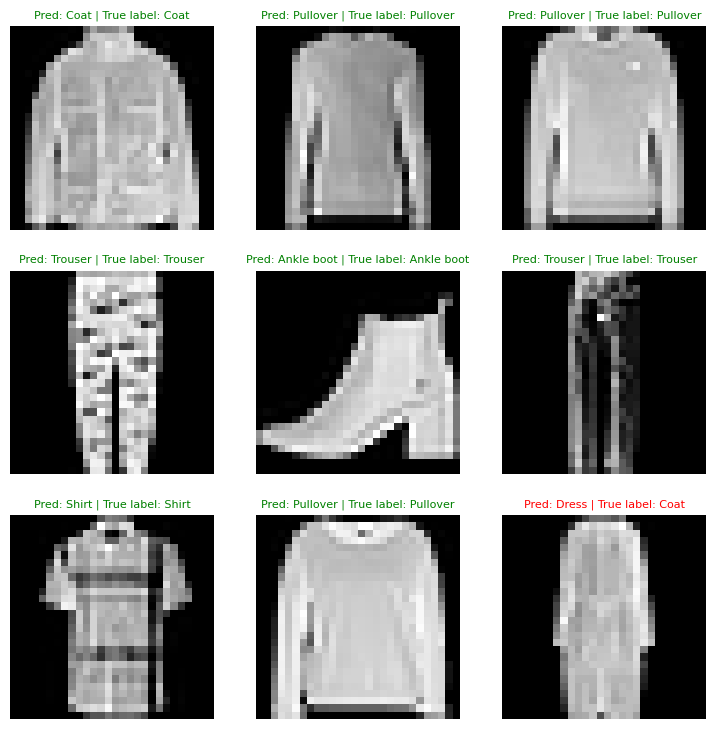

In [43]:
# plot results
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(sample_data):
    # create a subplot
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap='gray')
    plt.axis(False)

    if pred_probs[i] == truth_label[i]:
        plt.title(label=f"Pred: {class_names[pred_probs[i]]} | True label: {class_names[truth_label[i]]}", c='g', size=8)
    else:
        plt.title(label=f"Pred: {class_names[pred_probs[i]]} | True label: {class_names[truth_label[i]]}", c='r', size=8)

